In [283]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr, spearmanr, kendalltau, wilcoxon

In [284]:
PATH_AGREEMENT = '../data/annotator-agreement/'
PATH_IMAGES = '../assets/images/'

EXP_1 = 'exp_1.csv'
EXP_2 = 'exp_2.csv'

## Data loading

- Experiment 1: Survey with 15 annotators, 20 reviews, 4 ranked categories, a few guidelines.
- Experiment 2: Only me and another annotator, 4 ranked categories, prior discussion about the scheme and precise guidelines.

In [285]:
e_1 = pd.read_csv(PATH_AGREEMENT + EXP_1)
e_2 = pd.read_csv(PATH_AGREEMENT + EXP_2)

## Experiment 1

In [286]:
prim = e_1.dropna().copy()
if 'Unnamed: 0' in prim.columns:
    prim = prim.drop('Unnamed: 0', axis=1)

We remove 2 reviews and 2 annotators that were provoking heavy noise in the data.

In [287]:
prim = prim.drop(index=[14, 16], columns=['14', '5'])

Copy the DataFrame for the second part of the experiment

In [288]:
sec = prim.copy()

#### Part 1

In [289]:
prim['mean'] = prim.mean(axis=1)

In [290]:
prim['std'] = prim.std(axis=1)

In [291]:
prim['our'] = [2, 2, 3, 1, 4, 2, 1, 3, 3, 3, 4, 2, 3, 1, 4, 2, 2, 3]

In [292]:
prim['difference'] = prim['our'] - prim['mean']

In [293]:
prim_metric = prim.drop(['mean', 'std', 'difference'], axis=1)

#### Fleiss $\kappa$

In [294]:
prim_cpt = np.asarray([
    [4,6,4,0],
    [0,3,5,6],
    [0,2,5,7],
    [4,8,2,0],
    [0,0,0,14],
    [3,9,2,0],
    [2,12,0,0],
    [0,0,11,3],
    [0,0,10,4],
    [0,0,11,3],
    [0,0,4,10],
    [3,8,3,0],
    [0,0,3,11],
    [4,6,4,0],
    [0,0,8,6],
    [1,9,4,0],
    [3,9,2,0],
    [0,1,10,3]
])

def fleiss_kappa(M):
  """
  See `Fleiss' Kappa <https://en.wikipedia.org/wiki/Fleiss%27_kappa>`_.
  :param M: a matrix of shape (:attr:`N`, :attr:`k`) where `N` is the number of subjects and `k` is the number of categories into which assignments are made. `M[i, j]` represent the number of raters who assigned the `i`th subject to the `j`th category.
  :type M: numpy matrix
  """
  N, k = M.shape  # N is # of items, k is # of categories
  n_annotators = float(np.sum(M[0, :]))  # # of annotators

  p = np.sum(M, axis=0) / (N * n_annotators)
  P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
  Pbar = np.sum(P) / N
  PbarE = np.sum(p * p)

  kappa = (Pbar - PbarE) / (1 - PbarE)

  return kappa

In [295]:
fleiss_kappa(prim_cpt)

0.3094930463003469

#### Part 2

In [296]:
sec['15'] = [2, 2, 3, 1, 4, 2, 1, 3, 3, 3, 4, 2, 3, 1, 4, 2, 2, 3]

In [297]:
sec = sec.T

In [298]:
sec_mean = np.asarray(sec.mean(axis=1))

#### Plotting

In [299]:
labels = list(range(1, 19))
x = np.arange(len(labels))
xlin = np.linspace(x.min(), x.max(), 200)

width = 0.27

In [300]:
sec_mean = sec.mean(axis=0)

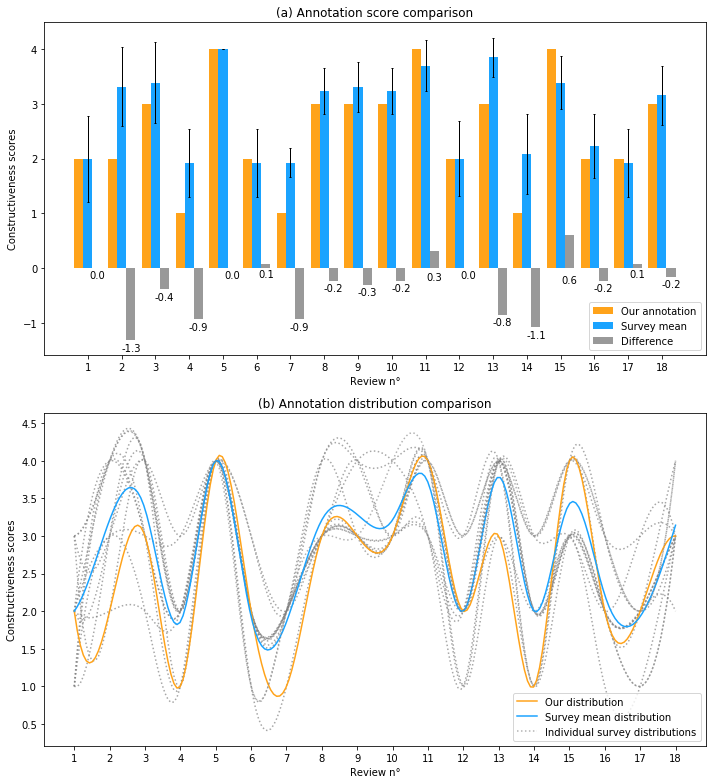

In [307]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11))

# Part 1

rects1 = ax1.bar(x - width, np.asarray(prim['our']), width, color='#ffa31a', label='Our annotation')
rects2 = ax1.bar(x, np.asarray(prim['mean']), width, color='#1aa3ff', yerr=np.asarray(prim['std']), error_kw=dict(ecolor='black', lw=1, capsize=1, capthick=1), label='Survey mean')
rects3 = ax1.bar(x + width, np.asarray(prim['difference']), width, color='grey', alpha=0.8, label='Difference')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title('(a) Annotation score comparison')
ax1.set_ylabel('Constructiveness scores')
ax1.set_xlabel('Review n°')
# ax.set_title('Annotation Agreement')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

        ax1.annotate('{0:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, height - 2 if height <= 0 else -(height*100/1.5)),
                    textcoords="offset pixels",
                    ha='center', va='top')

autolabel(rects3)

# Part 2

for annot in np.asarray(sec)[:-2]:
    spl = make_interp_spline(x, annot, k=3)  # type: BSpline
    power_smooth = spl(xlin)
    ax2.plot(xlin, power_smooth, 'grey', alpha=0.7, linestyle='dotted')

spl = make_interp_spline(x, np.asarray(sec)[-1], k=3)  # type: BSpline
power_smooth = spl(xlin)
ax2.plot(xlin, power_smooth, '#ffa31a', alpha=1, linestyle='solid', label='Our distribution')

spl = make_interp_spline(x, sec_mean, k=3)  # type: BSpline
power_smooth = spl(xlin)
ax2.plot(xlin, power_smooth, '#1aa3ff', alpha=1, linestyle='solid', label='Survey mean distribution')

spl = make_interp_spline(x, np.asarray(sec)[-2], k=3)  # type: BSpline
power_smooth = spl(xlin)
ax2.plot(xlin, power_smooth, 'grey', alpha=0.6, linestyle='dotted', label='Individual survey distributions')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title('(b) Annotation distribution comparison')
ax2.set_ylabel('Constructiveness scores')
ax2.set_xlabel('Review n°')
# ax.set_title('Annotation Agreement')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='lower right')

fig.tight_layout()

fig.savefig(PATH_IMAGES + 'agreement_4classes_2figures_blueorange.png', format='png', bbox_inches='tight')
plt.show()

## Experiment 2

In [17]:
e_2 = e_2.dropna().copy()
if 'Unnamed: 0' in e_2.columns:
    e_2 = e_2.drop('Unnamed: 0', axis=1)

In [28]:
annot1, annot2 = np.asarray(e_2['annot_1']), np.asarray(e_2['annot_2'])

In [59]:
def repl_val(n):
    if n == 'a':
        return 0
    elif n == 'b':
        return 1
    elif n == 'c':
        return 2
    elif n == 'd':
        return 3
    else:
        return np.nan

int_annot1 = list(map(repl_val, annot1))
int_annot2 = list(map(repl_val, annot2))

bin_annot1 = [0 if x == 'a' or x == 'b' else 1 for x in annot1]
bin_annot2 = [0 if x == 'a' or x == 'b' else 1 for x in annot2]

#### Computing various metrics

In [122]:
print("Cohen's kappa - 4 classes:", cohen_kappa_score(int_annot1, int_annot2, weights='quadratic'))
print("Cohen's kappa - 2 classes:", cohen_kappa_score(bin_annot1, bin_annot2, weights='quadratic'))
print("")

print("Spearman's rho - 4 classes:", spearmanr(int_annot1, int_annot2)[0], spearmanr(int_annot1, int_annot2)[1])
print("Spearman's rho - 2 classes:", spearmanr(bin_annot1, bin_annot2)[0], spearmanr(bin_annot1, bin_annot2)[1])
print("")

print("Person's correlation - 4 classes:", pearsonr(int_annot1, int_annot2))
print("Person's correlation - 2 classes:", pearsonr(bin_annot1, bin_annot2))
print("")

print("Kendall's tau - 4 classes:", kendalltau(int_annot1, int_annot2)[0], kendalltau(int_annot1, int_annot2)[1])
print("Kendall's tau - 2 classes:", kendalltau(bin_annot1, bin_annot2)[0], kendalltau(bin_annot1, bin_annot2)[1])
print("")

print("Wilcoxon's signed rank test - 4 classes:", wilcoxon(int_annot1, int_annot2, 'pratt')[0], wilcoxon(int_annot1, int_annot2, 'pratt')[1])
print("Wilcoxon's signed rank test - 2 classes:", wilcoxon(bin_annot1, bin_annot2, 'pratt')[0], wilcoxon(bin_annot1, bin_annot2, 'pratt')[1])

Cohen's kappa - 4 classes: 0.7572815533980582
Cohen's kappa - 2 classes: 0.7906197654941374

Spearman's rho - 4 classes: 0.8351969991875762 4.66793722808342e-14
Spearman's rho - 2 classes: 0.7969335501652227 4.414279606748595e-12

Person's correlation - 4 classes: (0.8227464470410826, 2.3091143261145734e-13)
Person's correlation - 2 classes: (0.7969335501652225, 4.414279606748695e-12)

Kendall's tau - 4 classes: 0.7778825782779683 5.474114292416332e-10
Kendall's tau - 2 classes: 0.7969335501652227 2.4255288368277895e-08

Wilcoxon's signed rank test - 4 classes: 123.0 0.0028599382084640882
Wilcoxon's signed rank test - 2 classes: 48.0 0.17971249487899976


#### Ploting the distributions

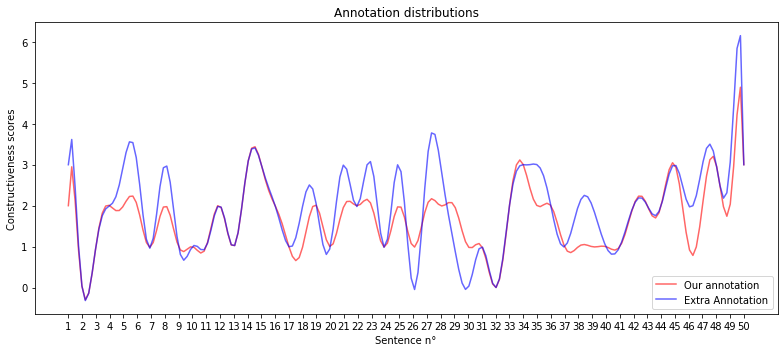

In [281]:
fig, ax = plt.subplots(figsize=(11, 5))

labels = list(range(1, 51))
x = np.arange(len(labels))
xlin = np.linspace(x.min(), x.max(), 200)


for i, color, label in ((int_annot1, 'red', 'Our annotation'), (int_annot2, 'blue', 'Extra Annotation')):
    spl = make_interp_spline(x, i, k=7)  # type: BSpline
    power_smooth = spl(xlin)
    ax.plot(xlin, power_smooth, color, alpha=0.6, linestyle='solid', label=label)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Annotation distributions')
ax.set_ylabel('Constructiveness scores')
ax.set_xlabel('Sentence n°')
# ax.set_title('Annotation Agreement')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

fig.tight_layout()

#fig.savefig(PATH_IMAGES + 'agreement_4classes_2figures.png', format='png', bbox_inches='tight')
plt.show()